In [1]:
import sys
sys.path.append('/home/albert/github/tensorflow/src/')
import evaluation
import data
sys.path.append('/home/albert/github/tensorflow/')
import densenet
import dense

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from scipy import misc

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
test_dict, test_files = data.get_data('test')

In [10]:
file_root = 'densenet_triplet'
file_name = file_root + '_' + str(13000)
weights_file = '/home/albert/github/tensorflow/models/%s/%s.npy' % (file_root, file_name)

input_shape = (256,128)
model_overall = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), weights=None)
model_overall.set_weights(np.load(weights_file))

In [4]:
file_root = 'densenet_triplet_cam_neck'
file_name = file_root + '_' + str(7000)
weights_file = '/home/albert/github/tensorflow/models/%s/%s.npy' % (file_root, file_name)

input_shape = (256,128)
model_keypoint = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), cam_placement=[3], weights=None)
model_keypoint.set_weights(np.load(weights_file))

16 8


In [11]:
cam_model_overall = Model(inputs=model_overall.input, outputs=model_overall.layers[-6].output)
cam_model_overall.compile(loss=categorical_crossentropy,
                  optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [6]:
cam_model_keypoint = Model(inputs=model_keypoint.input, outputs=model_keypoint.layers[-6].output)
cam_model_keypoint.compile(loss=categorical_crossentropy,
                  optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [36]:
batch = data.output_batch_generator(test_dict, P=4, preprocess=False,
                                    shape=(256,128), keypoints=['Neck'], r=0.25).next()
n = 10
im = batch[0]['input_im'][n]
cam = cv2.resize(255 * batch[0]['input_cam'][n], (8,16)).astype(np.uint8)

im_proc = densenet.preprocess_input(im.copy())

preprocess False
keypoints ['Neck']


In [37]:
pred_overall = cam_model_overall.predict(im_proc.reshape(1, im_proc.shape[0], im_proc.shape[1], 3))

input_dict = {'input_im' : im_proc.reshape(1,input_shape[0],input_shape[1],3), 'input_cam' : np.ones((1,128,64))}
pred_keypoint = cam_model_keypoint.predict(input_dict)

In [38]:
cam_sum_overall = np.sum(np.squeeze(pred_overall), axis=2)
cam_sum_overall = (cam_sum_overall - cam_sum_overall.min()) * 255.0 / \
                    (cam_sum_overall - cam_sum_overall.min()).max()

cam_sum_keypoint = np.sum(np.squeeze(pred_keypoint), axis=2)
cam_sum_keypoint = (cam_sum_keypoint - cam_sum_keypoint.min()) * 255.0 / \
                    (cam_sum_keypoint - cam_sum_keypoint.min()).max()

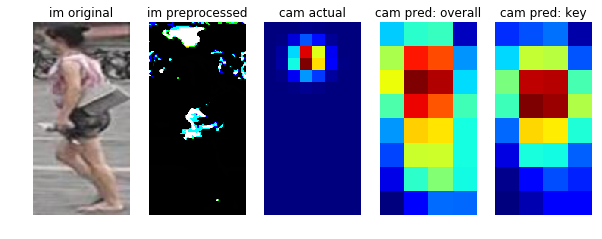

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(151)
plt.imshow(im.astype(np.uint8))
plt.axis('off')
plt.title('im original')

plt.subplot(152)
plt.imshow(im_proc.astype(np.uint8))
plt.axis('off')
plt.title('im preprocessed')

plt.subplot(153)
plt.imshow(cam, cmap=plt.cm.jet)
plt.axis('off')
plt.title('cam actual')

plt.subplot(154)
plt.imshow(cam_sum_overall.astype(np.uint8), cmap=plt.cm.jet)
plt.axis('off')
plt.title('cam pred: overall')

plt.subplot(155)
plt.imshow(cam_sum_keypoint.astype(np.uint8), cmap=plt.cm.jet)
plt.axis('off')
plt.title('cam pred: key')

plt.show()